Please upload the Telco-Customer-Churn CSV file (e.g., Telco-Customer-Churn.csv).


Saving train.csv to train.csv
Loaded: train.csv shape: (891, 12)
After dropping missing rows shape: (183, 12)
After encoding shape: (183, 450)
Features scaled. Shape: (183, 450)


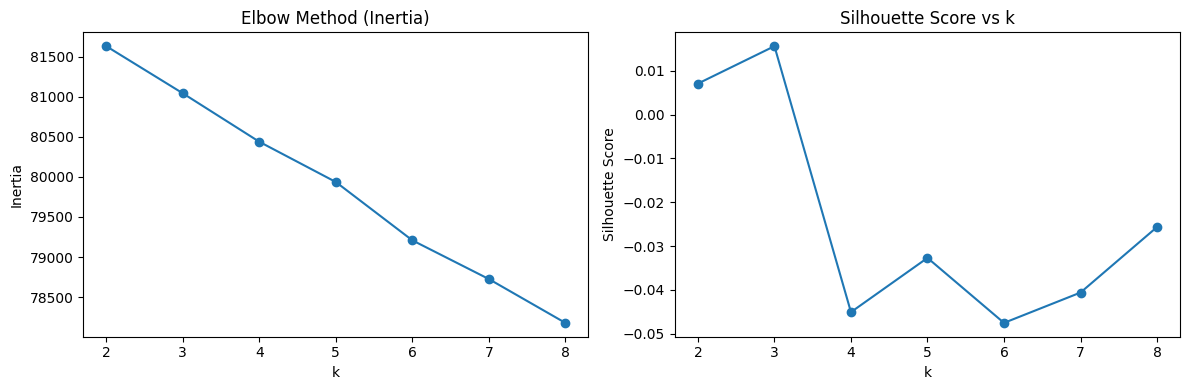

Selected k = 3 (best silhouette = 0.0157)


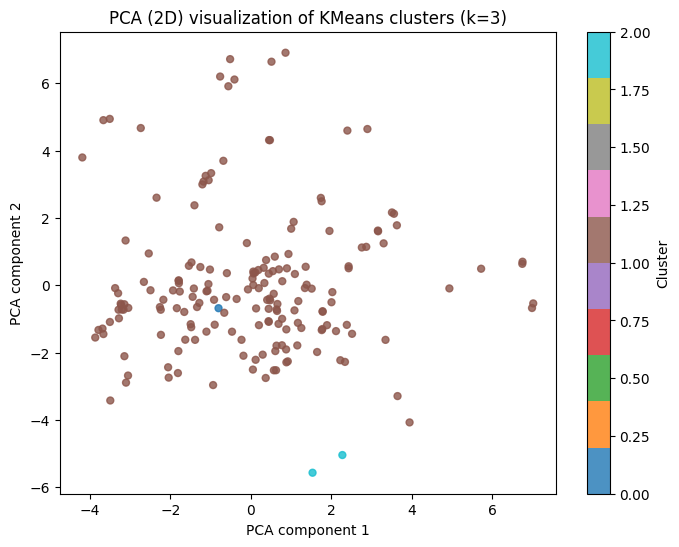


Cluster counts:
cluster
0      1
1    180
2      2
Name: count, dtype: int64

Final silhouette score for k=3: 0.0157

Assignment run complete. Use the PCA plot and cluster summaries for your report.


In [2]:
# Google Colab: Assignment-only script — KMeans clustering + PCA 2D visualization
# Paste into one cell and run. Upload Telco-Customer-Churn.csv when asked.
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ----------------------------
# 1) Upload dataset (Colab file picker)
# ----------------------------
print("Please upload the Telco-Customer-Churn CSV file (e.g., Telco-Customer-Churn.csv).")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded. Re-run the cell and upload the CSV.")
fn = list(uploaded.keys())[0]
df = pd.read_csv(fn)
print("Loaded:", fn, "shape:", df.shape)

# ----------------------------
# 2) Basic cleaning (assignment-focused)
# ----------------------------
# Drop identifier if present
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Convert TotalCharges to numeric and drop rows with NaN (simple approach for assignment)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop any remaining missing rows
df = df.dropna().reset_index(drop=True)
print("After dropping missing rows shape:", df.shape)

# ----------------------------
# 3) Encode categorical variables (simple & reliable for assignment)
# ----------------------------
# Map common Yes/No and gender to 0/1 for simplicity
binary_map = {'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0}
df = df.replace(binary_map)

# One-hot encode remaining object (string) columns
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

print("After encoding shape:", df.shape)

# ----------------------------
# 4) Feature matrix and scaling
# ----------------------------
X = df.copy()  # use all preprocessed features for clustering (assignment scope)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled. Shape:", X_scaled.shape)

# ----------------------------
# 5) Choose k: Elbow + Silhouette (k from 2 to 8)
# ----------------------------
Ks = range(2, 9)
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot Elbow and Silhouette side-by-side
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(Ks), inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(list(Ks), sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Pick best k by highest silhouette score (simple assignment rule)
best_k = Ks[int(np.argmax(sil_scores))]
print(f"Selected k = {best_k} (best silhouette = {max(sil_scores):.4f})")

# ----------------------------
# 6) Fit final K-Means and add cluster labels
# ----------------------------
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)
df['cluster'] = clusters

# ----------------------------
# 7) PCA to 2D and visualize clusters
# ----------------------------
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)
df['pca1'] = components[:,0]
df['pca2'] = components[:,1]

plt.figure(figsize=(8,6))
scatter = plt.scatter(df['pca1'], df['pca2'], c=df['cluster'], s=25, cmap='tab10', alpha=0.8)
plt.title(f'PCA (2D) visualization of KMeans clusters (k={best_k})')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.grid(False)
plt.colorbar(scatter, label='Cluster')
plt.show()

# ----------------------------
# 8) Simple cluster summary (means of selected features)
# ----------------------------
# Show cluster counts and a few mean feature values to interpret clusters
print("\nCluster counts:")
print(df['cluster'].value_counts().sort_index())

# Example: show mean of tenure, MonthlyCharges, TotalCharges if present
summary_cols = []
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        summary_cols.append(col)
summary = df.groupby('cluster')[summary_cols].mean().round(3)
if not summary.empty:
    print("\nCluster feature means:")
    display(summary)

# ----------------------------
# 9) Silhouette score for final clustering
# ----------------------------
final_sil = silhouette_score(X_scaled, clusters)
print(f"\nFinal silhouette score for k={best_k}: {final_sil:.4f}")

# End of assignment-focused script
print("\nAssignment run complete. Use the PCA plot and cluster summaries for your report.")
